# Sleep Prediction - Unlocking the Secrets of Restful Nights
## In this problem we have to predict the sleep time. 

We have 8 years of historic health data taken from various devices including: Fitbit, Apple Watch and iPhone. <br>
This valuable data encompassed crucial metrics including step count, heart rate, exercise time, and energy burned.

### In this notebook we will implement an Ensemble Model
We will train Individual Model with Hyper-parameter tuning using GridSearchCV, after which we will implement esemble model with following learners: <br>
1. Decision Tree
2. Rnadom Forest
2. ADA Boost
3. Gradient Boost
4. XGBoost
    
**So Let's get started with our eyes wide open Or..!!**

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExNTQ3YWZhOTI3ODNkOGE1ZGFjNzRlYjQzMTlhNDc3NzA4ZWQwOGRmYSZlcD12MV9pbnRlcm5hbF9naWZzX2dpZklkJmN0PWc/vMbC8xqhIf9ny/giphy.gif" alt="Cat GIF" width="400" height="400">


In [1]:
# Check CUDA
!nvidia-smi

Fri May 26 09:45:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tqdm.notebook import tqdm

import os
import re
import sys

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers

import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
HOME = '/kaggle/working/'
HOMEDATA = '/kaggle/input/kaggle-pog-series-s01e04/'

# Load Training Data

In [4]:
train = pd.read_csv(f'{HOMEDATA}FinalTrain.csv', parse_dates=['date'], index_col='date')
train.head()

,sleep_hours
date,
2015-02-19,6.400000
2015-02-20,7.583333
2015-02-21,6.350000
2015-02-22,6.500000
2015-02-23,8.916667


In [6]:
train.shape

(2354, 1)

# Include XML files with train

In [9]:
# Useful files and their aggregating methods
useful_files = {'StepCount.csv': 'sum',
                'HeartRate.csv': 'max',
                'DistanceWalkingRunning.csv': None, #--special treatment
                'BasalEnergyBurned.csv': 'sum',
                #'FlightsClimbed.csv',         #-- not seem fit
                'ActiveEnergyBurned.csv': 'sum',
                'Workout.csv': 'sum',
                'BodyMass.csv': 'max'}

In [10]:
def xml_data (data):
    temp = data.copy()
    for file in useful_files.keys():
        # Load file
        date_columns = ['startDate']
        if(file == 'Workout.csv'):
            data = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','duration'])
            data.rename(columns = {'duration':'value'}, inplace=True)
        else: 
            data = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'])
        data = data.sort_values('startDate').reset_index(drop=True)
        
        # Parse & Format the date
        for col in date_columns:
            data[col] = pd.to_datetime(data[col]).dt.tz_convert(None) #remove the UTC component, -0400
            data[col] = pd.to_datetime(data[col].apply(lambda x:x.strftime('%Y-%m-%d')))
    
        # Pre-process data 
        if file != 'DistanceWalkingRunning.csv':
            data = data.groupby('startDate').aggregate({'value': useful_files[file]})
        else:
            # Computation method for DistanceWalkingRunning
            dates = data['startDate'].unique()
            data_dict = {}
            for i, date in enumerate(dates):
                temp_dist = data[data['startDate'] == date]
                if max(temp_dist['value'].values) > 1:
                    data_dict[i] = (date, max(temp_dist['value'].values))
                else:
                    data_dict[i] = (date, sum(temp_dist['value'].values))
            data = pd.DataFrame(data_dict).T
            data.columns = ['startDate', 'value']
            data['value'] = data['value'].astype(float)
            data['startDate'] = pd.to_datetime(data['startDate'])
            data.set_index('startDate', inplace=True)
        
        # Merge with df
        trail = pd.merge(temp, data, how='inner', left_index = True, right_index = True)
        temp[file.split('.')[0]] = trail['value']
    return temp

### Impute Nan values of XML file

In [12]:
def xml_impute (data):
    temp = data.copy()
    print('Pre-Imputation\n', temp.isna().sum())
    temp.loc[((~pd.isnull(temp['Workout'])) & (pd.isnull(temp['HeartRate']))), 'HeartRate'] = \
            temp.loc[~pd.isnull(temp['Workout']), 'HeartRate'].mean()
    temp.loc[pd.isnull(temp['HeartRate']), 'HeartRate'] = 110
    temp['BasalEnergyBurned'] = temp['BasalEnergyBurned'].fillna(method='bfill')
    temp['BodyMass'] = temp['BodyMass'].fillna(method='ffill')
    temp.loc[pd.isnull(temp['Workout']), 'Workout'] = 0
    
    dates_na = temp[pd.isnull(temp['ActiveEnergyBurned'])].index
    # ActiveEnergyBurned - previous 7 days average
    for date in dates_na:
        impute_val = temp[((temp.index >= date - pd.DateOffset(days=7)) & \
                                    (temp.index < date))]['ActiveEnergyBurned']
        temp.loc[(temp.index == date), 'ActiveEnergyBurned'] = impute_val.mean()
    print('Post-Imputation\n', temp.isna().sum())
    return temp

# Feature Engineering

In [17]:
def createDateFeatures(data):
    temp = data.copy()
    temp['day'] = temp.index.day
    temp['month'] = temp.index.month
    temp['year'] = temp.index.year
    temp['weekofyear'] = temp.index.isocalendar().week.astype('int')
    temp['weekday'] = temp.index.weekday
    temp['dayofyear'] = temp.index.day_of_year
    
    temp['date_offset'] = (temp.index.month * 100 + temp.index.day - 320) % 1300
    temp['season'] = pd.cut(temp['date_offset'], 
                            bins=[0, 300, 602, 900, 1300],
                            labels=['spring', 'summer', 'fall', 'winter'])
    temp.drop('date_offset', axis=1, inplace=True)
    
    temp2 = pd.get_dummies(temp['season'])
    temp.drop('season', axis=1, inplace=True)
    temp = temp.merge(temp2, how='left', left_index=True, right_index=True)
    
    return temp

In [19]:
'''
    Our forecasting horizon is >1 years, 
    hence for lag of days, we'll compute iteratively from previous predictions.
'''
# Lag Features
def createLagFeatures(data):
    temp = data.copy()
    n=3 # Num of Lags
    # Day lag (3 days)
    for i in range(1, n+1):
        temp[f'day_lag_{i}'] = temp['sleep_hours'].shift(i)
        temp[f'day_lag_{i}'] = temp[f'day_lag_{i}'].bfill()
    # Year lag (1 year)
    temp[f'year_lag_{1}'] = temp['sleep_hours'].shift(364)
    temp[f'year_lag_{1}'] = temp[f'year_lag_{1}'].bfill()
    return temp

def random_noise(data):
    return np.random.normal(scale=1.5, size=(len(data)))
# Roll mean Features
def createRollMeanFeatures(data):
    windows = [3,7,14,28]
    temp = data.copy()
    for window in windows:
        temp['roll_mean_' + str(window)] = \
            temp['sleep_hours'].shift(1).rolling(window=window, win_type="triang").mean() \
                + random_noise(temp)
        temp['roll_mean_' + str(window)] = temp['roll_mean_' + str(window)].bfill()
    return temp

# Exponential Weighted Moving Average
def createEWMFeatures(data):
    alphas = [0.95,0.8]
    lags = [3,7,14,28]
    temp = data.copy()
    for alpha in alphas:
        for lag in lags:
            temp['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                temp['sleep_hours'].shift(lag).ewm(alpha=alpha).mean()
            temp['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                temp['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)].bfill()
    return temp

In [21]:
import holidays

def get_holidays(df):
    years_list = np.arange(train_new.index.year.min(), train_new.index.year.max()+1)

    holiday_US = holidays.CountryHoliday('US', years = years_list)

    df['holiday_name'] = df.index.map(holiday_US)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df.drop(columns = ['holiday_name'])

# Split Feature and Target

In [ ]:
X = train.drop('sleep_hours', axis=1)
y = train['sleep_hours']

In [ ]:
X.columns

# Train and Validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# Ensemble Model

In [29]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## Individual Learners

In [30]:
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

from sklearn.metrics import make_scorer
my_scorer = make_scorer(rmse, greater_is_better=False)

def grid_search(model, searchSpace, x, y, verbose=4, cv = 5):
    np.random.seed(42)
    
    # Initialize GridSearchCV
    gs = GridSearchCV(model, param_grid=searchSpace, scoring=my_scorer, cv=cv, refit=True, verbose=verbose)
    
#     # Use tqdm to create a loading bar
#     total_params = [len(searchSpace[key]) for key in searchSpace.keys()]
#     total_params = math.prod(total_params)
    
#     with tqdm(total=total_params, desc="Grid Search Progress") as pbar:
#         # Custom progress bar update function
#         def update_progress(estimator, X, y):
#             pbar.update(1)  # Increment the progress bar

#         # Set the progress callback
#         gs.progress_callback = update_progress

    # Fit the grid search to the data
    gs.fit(x, y)
    
    # Print the best parameters and score
    print()
    print("Best parameters: ", gs.best_params_)
    print("Best score: ", gs.best_score_)
    
    return gs

### Decision Tree

In [75]:
dec_tree = DecisionTreeRegressor(random_state=42)

# SearchSpace
searchSpace = {
    'criterion': ["squared_error", "friedman_mse"],
    'max_depth': [5, 15, 30, 50],
    'min_samples_split': [2, 4, 10]
}

dec_gs = grid_search(dec_tree, searchSpace, X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.119 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.119 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.118 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=4;, score=-0.119 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=4;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=4;, score=-0.113 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=4;, score=-0.119 total time= 

In [78]:
''' By previous GridSearch Run, it looks like we can go higher on min_samples_split '''

# SearchSpace
searchSpace = {
    'criterion': ["squared_error"],
    'max_depth': [5],
    'min_samples_split': [10, 15, 20]
}

dec_gs = grid_search(dec_tree, searchSpace, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.120 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.116 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.118 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=15;, score=-0.120 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=15;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=15;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=15;, score=-0.117 total

In [83]:
''' Let's set even higher value for min_samples_split '''

# SearchSpace
searchSpace = {
    'criterion': ["squared_error"], 
    'max_depth': [5],
    'min_samples_split': [20, 50, 100, 150, 500, 1000, 2000]
}

dec_gs = grid_search(dec_tree, searchSpace, X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.120 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.117 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.118 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.120 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.116 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.114 total

In [84]:
score = cross_val_score(dec_gs, X_train, y_train, cv=10)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.119 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.114 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.114 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.111 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.121 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.119 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.112 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.114 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.109 total

In [85]:
score

array([-0.11681739, -0.11050197, -0.10987398, -0.11138552, -0.10992735,
       -0.11027842, -0.11288172, -0.10206279, -0.10795301, -0.1180055 ])

**Scores are pretty descent**

### Random Forest

In [89]:
ran_forest = RandomForestRegressor(random_state=42, max_features='sqrt', bootstrap=True)

# SearchSpace
searchSpace = {
    'n_estimators': [50, 100, 200],
    'criterion': ["squared_error", "friedman_mse"], 
    'max_depth': [5, 15, 30, 50],
    'min_samples_split': [2, 4, 10]
}

ran_gs = grid_search(ran_forest, searchSpace, X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.112 total time=   0.2s
[CV 2/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.108 total time=   0.2s
[CV 3/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.109 total time=   0.2s
[CV 4/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.107 total time=   0.2s
[CV 5/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.110 total time=   0.2s
[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.112 total time=   0.3s
[CV 2/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=100;, sc

In [90]:
ran_forest = RandomForestRegressor(random_state=42, max_features='sqrt', bootstrap=True)

# SearchSpace
searchSpace = {
    'n_estimators': [200, 300, 400],
    'criterion': ["friedman_mse"],
    'max_depth': [5],
    'min_samples_split': [2]
}

ran_gs = grid_search(ran_forest, searchSpace, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.112 total time=   0.6s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.108 total time=   0.6s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.108 total time=   0.6s
[CV 4/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.107 total time=   0.6s
[CV 5/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.110 total time=   0.6s
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.112 total time=   0.9s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.108 total time=   0.9s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=30

In [91]:
ran_forest = RandomForestRegressor(random_state=42, max_features='sqrt', bootstrap=True)

# SearchSpace
searchSpace = {
    'n_estimators': [400, 600, 800],
    'criterion': ["friedman_mse"],
    'max_depth': [5],
    'min_samples_split': [2]
}

ran_gs = grid_search(ran_forest, searchSpace, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.112 total time=   1.2s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.108 total time=   1.2s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.108 total time=   1.2s
[CV 4/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.107 total time=   1.2s
[CV 5/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.110 total time=   1.2s
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=600;, score=-0.112 total time=   1.9s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=600;, score=-0.108 total time=   1.9s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=60

In [93]:
score = cross_val_score(ran_gs, X_train, y_train, cv=10)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.111 total time=   1.2s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.106 total time=   1.2s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.110 total time=   1.3s
[CV 4/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.106 total time=   1.2s
[CV 5/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.110 total time=   1.2s
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=600;, score=-0.110 total time=   1.8s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=600;, score=-0.106 total time=   1.8s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=60

In [94]:
score

array([-0.11480452, -0.1103527 , -0.10898201, -0.10733326, -0.10842364,
       -0.10791492, -0.11135623, -0.10268021, -0.10291638, -0.11710867])

### ADA Boost

In [32]:
ada_boost = AdaBoostRegressor(random_state=42)

# SearchSpace
searchSpace = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

ada_gs = grid_search(ada_boost, searchSpace, X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=-0.113 total time=   0.5s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=-0.109 total time=   0.5s
[CV 3/5] END learning_rate=0.01, n_estimators=50;, score=-0.108 total time=   0.5s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=-0.107 total time=   0.5s
[CV 5/5] END learning_rate=0.01, n_estimators=50;, score=-0.111 total time=   0.5s
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=-0.112 total time=   1.1s
[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=-0.109 total time=   1.1s
[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=-0.108 total time=   1.1s
[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=-0.106 total time=   1.1s
[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=-0.111 total time=   1.1s
[CV 1/5] END learning_rate=0.01, n_estimators=200;, score=-0.112 total time=   2.1s
[CV 2/5] END learnin

In [35]:
score = cross_val_score(ada_boost, X_train, y_train, cv=10)

In [36]:
score

array([ 0.0296562 ,  0.03034349,  0.06617951, -0.00294066,  0.0251807 ,
        0.02260289,  0.02708428, -0.02191224, -0.06104863, -0.04501389])

### Gradient Boost

In [41]:
grad_boost = GradientBoostingRegressor(random_state=42, max_features='sqrt')

# SearchSpace
searchSpace = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [5, 15, 30, 50],
    'min_samples_split': [2, 4, 10]
}

grad_gs = grid_search(grad_boost, searchSpace, X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.113 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.110 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.109 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.108 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.110 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.113 total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.110 total time=   0.4s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.109 total time=   0.4

In [42]:
grad_boost = GradientBoostingRegressor(random_state=42, max_features='sqrt')

# SearchSpace
searchSpace = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01],
    'max_depth': [5],
    'min_samples_split': [4]
}

grad_gs = grid_search(grad_boost, searchSpace, X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.113 total time=   0.6s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.109 total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.109 total time=   0.6s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.107 total time=   0.6s
[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.111 total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=300;, score=-0.113 total time=   0.9s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=300;, score=-0.109 total time=   0.9s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=300;, score=-0.109 total time=   0

In [45]:
score = cross_val_score(grad_boost, X_train, y_train, cv=10)

In [46]:
score

array([ 0.00616488, -0.02473145, -0.01165732, -0.04140249,  0.03578469,
        0.0325899 ,  0.00890336, -0.02515419, -0.07727098, -0.04414416])

### XGBoost

In [ ]:
xg_boost = XGBRegressor(random_state=42, tree_method='gpu_hist', gpu_id=0)

# SearchSpace
searchSpace = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2, 0.5],
    'max_depth': [5, 15, 30, 50],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.3, 0.5, 0.7, 1]
}

xg_gs = grid_search(xg_boost, searchSpace, X_train, y_train)

[CV 3/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100;, score=-0.109 total time=   0.1s
[CV 4/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100;, score=-0.107 total time=   0.1s
[CV 5/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100;, score=-0.110 total time=   0.1s
[CV 1/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=200;, score=-0.113 total time=   0.2s
[CV 2/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=200;, score=-0.109 total time=   0.2s
[CV 3/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=200;, score=-0.109 total time=   0.2s
[CV 4/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=20

In [49]:
print("Best parameters: ", xg_gs.best_params_)
print("Best score: ", xg_gs.best_score_)

Best parameters:  {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50}
Best score:  -0.1093562521141489


In [106]:
from prettytable import PrettyTable

print("Individual Learners Performance")

table = PrettyTable()
table.field_names = ["Field",                   "Decision Tree", "Random Forest", "ADA Boost", "Gradient Boost", "XGBoost"]
table.add_row(      ["criterion",               "squared_error", "friedman_mse",  "-",         "-",               "-"     ])
table.add_row(      ["max_depth",                5,               5,              "-",         5,                 5       ])
table.add_row(      ["min_samples_split",        1000,            2,              "-",         4,                 "-"     ])
table.add_row(      ["n_estimators",             "-",             400,             100,        "-",               50      ])
table.add_row(      ["Learning Rate",            "-",             "-",             0.1,        0.01,              0.2     ])
table.add_row(      ["gamma",                    "-",             "-",            "-",         "-",               0.1     ])
table.add_row(      ["min_child_weight",         "-",             "-",            "-",         "-",               5       ])
table.add_row(      ["colsample_bytree",         "-",             "-",            "-",         "-",               0.5     ])
table.add_row(      ['------------------', '------------------', '------------------', '------------------', '------------------','------------------'])
table.add_row(      ["Neg. RMSE",                -0.1104,         -0.1092,         -0.1093,    -0.1095,           -0.1093 ])
table.add_row(      ['------------------', '------------------', '------------------', '------------------', '------------------','------------------'])
print(table)

Individual Learners Performance
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       Field        |   Decision Tree    |   Random Forest    |     ADA Boost      |   Gradient Boost   |      XGBoost       |
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     criterion      |   squared_error    |    friedman_mse    |         -          |         -          |         -          |
|     max_depth      |         5          |         5          |         -          |         5          |         5          |
| min_samples_split  |        1000        |         2          |         -          |         4          |         -          |
|    n_estimators    |         -          |        400         |        100         |         -          |         50         |
|   Learning Rate    |         -          |         -          |        

## Ensemble Training

In [60]:
# Define the number of models to train
n_models = 10

# Define the base learners
dt = DecisionTreeRegressor(criterion='squared_error', max_depth=5, min_samples_split=1000, random_state=42)
rf = RandomForestRegressor(criterion='friedman_mse', max_depth=5, min_samples_split=2, n_estimators=400, random_state=42)
ab = AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_split=4, random_state=42)
xgb = XGBRegressor( n_estimators=50, learning_rate=0.2, max_depth=5, colsample_bytree=0.5, gamma=0.1, min_child_weight=5, random_state=42)

# Define an empty list to store the models
models = []

np.random.seed(42)

# Train n models with different resampled datasets
for i in range(n_models):
    x_train_resampled = X_train.sample(frac=0.2).to_numpy() #here we converting to numpy array as we don't want to fit the model with feature names, as we will fit on single sample later (iteratively), which will raise feature importance error.
    selected_indices = X_train.sample(frac=0.2).index
    y_train_resampled = (y_train[selected_indices]).to_numpy()

    # Define the voting regressor
    voting_reg = VotingRegressor(
        estimators=[('dt', dt), ('rf', rf), ('ab', ab), ('gb', gb), ('xgb', xgb)], 
        verbose=True
    )
    
    # Fit the voting classifier on the resampled training data
    voting_reg.fit(x_train_resampled, y_train_resampled)
    
    # Append the trained model to the list of models
    models.append(voting_reg)

[Voting] ....................... (1 of 5) Processing dt, total=   0.0s
[Voting] ....................... (2 of 5) Processing rf, total=   1.5s
[Voting] ....................... (3 of 5) Processing ab, total=   0.5s
[Voting] ....................... (4 of 5) Processing gb, total=   0.5s
[Voting] ...................... (5 of 5) Processing xgb, total=   0.1s
[Voting] ....................... (1 of 5) Processing dt, total=   0.0s
[Voting] ....................... (2 of 5) Processing rf, total=   1.5s
[Voting] ....................... (3 of 5) Processing ab, total=   0.4s
[Voting] ....................... (4 of 5) Processing gb, total=   0.4s
[Voting] ...................... (5 of 5) Processing xgb, total=   0.1s
[Voting] ....................... (1 of 5) Processing dt, total=   0.0s
[Voting] ....................... (2 of 5) Processing rf, total=   1.6s
[Voting] ....................... (3 of 5) Processing ab, total=   0.3s
[Voting] ....................... (4 of 5) Processing gb, total=   0.4s
[Votin

In [103]:
y_preds = []
x = X_train.to_numpy()
for model in models:
    y_pred = model.predict(x)
    y_preds.append(y_pred)
y_pred_avg = np.mean(y_preds, axis=0)
y_pred_final = np.round(y_pred_avg, 2)

In [104]:
mse = mean_squared_error(y_train, y_pred_final)
rmse = np.sqrt(mse)
mape = np.round(mean_absolute_percentage_error(y_train, y_pred_final) * 100, 2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE: {} %".format(mape))

MSE: 0.012446967949336685
RMSE: 0.11156598025086628
MAPE: 4.76 %


# Predict on Test set

In [94]:
test_iter_target = test_merge.copy()
for i in tqdm(range(len(test))):
    data_val = test_iter_target.iloc[train_part_len+i,1:].to_numpy().reshape(1, -1)
    y_preds = []
    for model in models:
        y_pred = model.predict(data_val)
        y_preds.append(y_pred)
    y_pred_avg = np.mean(y_preds, axis=0)
    y_pred_final = np.round(y_pred_avg, 2)
    
    # update target iteratively with prediction
    test_iter_target.iloc[train_part_len+i,0] = y_pred_final
    # update roll_mean iteratively with prediction
    test_iter_target = createLagFeatures(test_iter_target)
    test_iter_target = createRollMeanFeatures(test_iter_target)
    test_iter_target = createEWMFeatures(test_iter_target)

  0%|          | 0/419 [00:00<?, ?it/s]

In [95]:
test_final = test_iter_target[test_iter_target.index.year>2021]

### Inverse log transformation

In [97]:
test_y = np.exp(test_final['sleep_hours'])

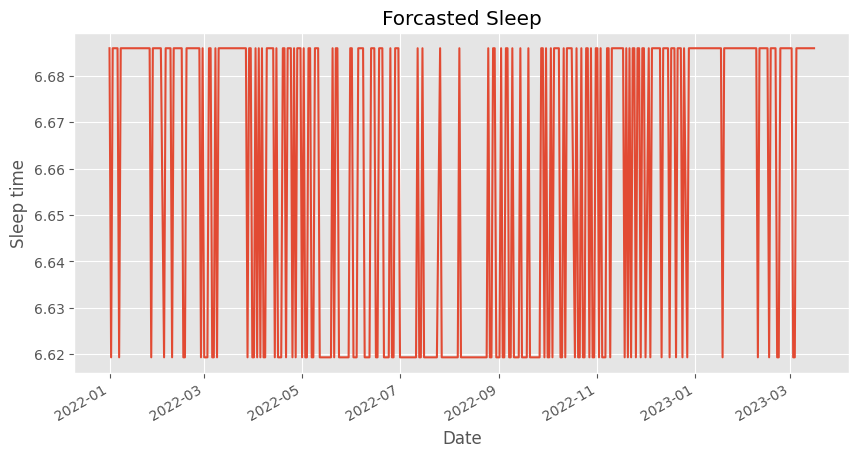

In [98]:
plt.figure(figsize=(10,5))
test_y.plot()
plt.title('Forcasted Sleep')
plt.ylabel('Sleep time')
plt.xlabel('Date')
plt.show()

# Conclusion

We have successfully implemented an Emsemble model with hyper-parameter tuning.

### Ensemble Model (Tree-Based):
Recognizing the potential for enhanced performance through model fusion, I crafted an ensemble model comprising various tree-based algorithms. Leveraging the collective strength of decision trees, random forests, ADA Boost, gradient boost, and XGBoost. By harnessing the individual strengths of each technique, we achieved superior predictive accuracy and generalizability.

MSE : 0.01244 <br>
RMSE : 0.11156 <br>
MAPE : 4.76 % <br>

#### <font color='Brown'> In this model we are on an average 7 minutes off of the ground truth, which is pretty good! </font>


# END